# Non-Conjugate Priors

This lecture is a sequel to the {doc}`quantecon lecture <prob_meaning>`.

That lecture offers a Bayesian interpretation of probability in a setting in which the likelihood function and the prior distribution
over parameters just happened to form a **conjugate** pair in which

-  application of Bayes' Law produces a posterior distribution that has the same functional form as the prior

Having a likelihood and prior that  are conjugate can simplify calculation of a posterior, faciltating  analytical or nearly analytical calculations.

But in many situations  the likelihood and prior need not form a conjugate pair.

 - after all, a person's prior is his or her own business and would take a form conjugate to a likelihood only by remote coincidence

In these situations, computing a posterior can become very challenging.  

In this lecture, we illustrate how modern Bayesians confront non-conjugate priors  by using  Monte Carlo techniques that involve 

- first  cleverly forming a Markov chain whose invariant distribution is the posterior distribution we want 
- simulating the Markov chain until it has converged and then sampling from the invariant distribution to approximate the posterior

We shall illustrate the approach by deploying two powerful Python modules that implement this approach as well as another closely related one to
be described below.  

The two Python modules are

- `numpyro`
- `pymc4`

As usual, we begin by importing some Python code.

In [1]:
# install dependencies
!pip install numpyro pyro-ppl torch jax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/732.8 kB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 20.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import binom
import scipy.stats as st
import torch

# jax
import jax.numpy as jnp
from jax import lax, random

# pyro
import pyro
from pyro import distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import MCMC, NUTS, SVI, ELBO, Trace_ELBO
from pyro.optim import Adam

# numpyro
import numpyro
from numpyro import distributions as ndist
import numpyro.distributions.constraints as nconstraints
from numpyro.infer import MCMC as nMCMC
from numpyro.infer import NUTS as nNUTS
from numpyro.infer import SVI as nSVI
from numpyro.infer import ELBO as nELBO
from numpyro.infer import Trace_ELBO as nTrace_ELBO
from numpyro.optim import Adam as nAdam


%matplotlib inline

## Unleashing MCMC on a  Binomial Likelihood

This lecture begins with the binomial example in the {doc}`quantecon lecture <prob_meaning>`.

That lecture computed a posterior 

- analytically via choosing the conjugate priors,

This lecture instead computes posteriors

- numerically by sampling from the posterior distribution through MCMC methods, and 
- using a variational inference (VI) approximation.

We use both the packages `pyro` and `numpyro` with assistance from  `jax` to approximate a  posterior distribution

We use several alternative prior distributions

We  compare computed posteriors  with ones associated with a conjugate prior as described in  {doc}`the quantecon lecture <prob_meaning>`


### Analytical Posterior

Assume that the random variable $X\sim Binom\left(n,\theta\right)$. 

This defines a likelihood function

$$
L\left(Y\vert\theta\right) = \textrm{Prob}(X =  k | \theta) = 
\left(\frac{n!}{k! (n-k)!} \right) \theta^k (1-\theta)^{n-k}
$$

where $Y=k$ is an observed data point.

We view  $\theta$ as a random variable for which we assign a prior distribution having density $f(\theta)$.

We will try alternative priors later, but for now, suppose the prior is distributed as $\theta\sim Beta\left(\alpha,\beta\right)$, i.e.,  

$$
f(\theta) = \textrm{Prob}(\theta) = \frac{\theta^{\alpha - 1} (1 - \theta)^{\beta - 1}}{B(\alpha, \beta)}
$$

We choose this as our prior for now because  we know that a conjugate prior for the binomial likelihood function is a beta distribution.


After observing  $k$ successes among $N$ sample observations, the posterior  probability distributionof  $ \theta $ is

$$
\textrm{Prob}(\theta|k) = \frac{\textrm{Prob}(\theta,k)}{\textrm{Prob}(k)}=\frac{\textrm{Prob}(k|\theta)\textrm{Prob}(\theta)}{\textrm{Prob}(k)}=\frac{\textrm{Prob}(k|\theta) \textrm{Prob}(\theta)}{\int_0^1 \textrm{Prob}(k|\theta)\textrm{Prob}(\theta) d\theta}
$$

$$
=\frac{{N \choose k} (1 - \theta)^{N-k} \theta^k \frac{\theta^{\alpha - 1} (1 - \theta)^{\beta - 1}}{B(\alpha, \beta)}}{\int_0^1 {N \choose k} (1 - \theta)^{N-k} \theta^k\frac{\theta^{\alpha - 1} (1 - \theta)^{\beta - 1}}{B(\alpha, \beta)} d\theta}
$$

$$
=\frac{(1 -\theta)^{\beta+N-k-1} \theta^{\alpha+k-1}}{\int_0^1 (1 - \theta)^{\beta+N-k-1} \theta^{\alpha+k-1} d\theta} .
$$



Thus, 

$$
\textrm{Prob}(\theta|k) \sim {Beta}(\alpha + k, \beta+N-k)
$$

The analytical posterior for a given conjugate beta prior is coded in the following Python code.

In [3]:
def simulate_draw(theta, n):
    """
    Draws a Bernoulli sample of size n with probability P(Y=1) = theta
    """
    rand_draw = np.random.rand(n)
    draw = (rand_draw < theta).astype(int)
    return draw


def analytical_beta_posterior(data, alpha0, beta0):
    """
    Computes analytically the posterior distribution with beta prior parametrized by (alpha, beta) 
    given # num observations

    Parameters
    ---------
    num : int.
        the number of observations after which we calculate the posterior
    alpha0, beta0 : float.
        the parameters for the beta distribution as a prior

    Returns
    --------- 
    The posterior beta distribution
    """
    num = len(data)
    up_num = data.sum()
    down_num = num - up_num
    return st.beta(alpha0 + up_num, beta0 + down_num)

### Two Ways to Approximate Posteriors

Suppose that we don't have a conjugate prior.

Then  we  can't compute posteriors analytically.

Instead,  we use computational tools to approximate the posterior distribution for a set of alternative prior distributions using both `Pyro` and `Numpyro` packages in Python. 

We first use the **Markov Chain Monte Carlo** (MCMC) algorithm .

We implement the NUTS sampler to sample from the posterior.

In that way we construct a sampling distribution that approximates the  posterior.

After doing that we deply another procedure called  **Variational Inference** (VI).  

In particular, we implement Stochastic Variational Inference (SVI) machinery in both `Pyro` and `Numpyro`. 

The MCMC algorithm  supposedly generates a more accurate approximation since in principle it directly samples from the posterior distribution.

But it  can be computationally expensive, especially when dimension is large.

A VI approach can be  cheaper, but it is likely to produce an inferior approximation to the posterior, for the simple reason that it requires guessing a parametric **guide functional form** that we use to approximate a posterior.

This guide function is likely  at best to be an imperfect approximation. 

By paying the cost of restricting the putative posterior to have a restricted functional form, 
the problem of approximating a posteriors is transformed to a well-posed optimization problem that seeks parameters of the putative posterior  that minimize
a Kullback-Leibler (KL) divergence between true posterior and the putatitive posterior  distribution.

  - minimizing the KL divergence is  equivalent with  maximizing a criterion called  the **Evidence Lower Bound** (ELBO), as we shall verify soon.

## Prior Distributions

In order to be able to apply MCMC sampling or VI, `Pyro` and `Numpyro` require  that a prior distribution satisfy special properties:

- we must be able sample from it;
- we must be able to  compute the log pdf  pointwise;
- the pdf must be  differentiable with respect to the parameters.

We'll want to define a distribution `class`.

We  will use the following priors:

-  a uniform distribution on $[\underline \theta, \overline \theta]$, where $0 \leq \underline \theta < \overline \theta \leq 1$. 
  
- a truncated log-normal distribution with support on $[0,1]$ with parameters $(\mu,\sigma)$. 

    - To implement this, let $Z\sim Normal(\mu,\sigma)$ and $\tilde{Z}$ be truncated normal with support $[\log(0),\log(1)]$, then $\exp(Z)$ has a log normal distribution with bounded support $[0,1]$. This can be easily coded since `Numpyro` has a built-in truncated normal distribution, and `Torch` provides a `TransformedDistribution` class that includes an exponential transformation.
    
    - Alternatively, we can use a rejection sampling strategy by assigning the probability rate to $0$ outside the bounds and rescaling accepted samples, i.e., realizations that are within the bounds, by the total probability computed via CDF of the original distribution. This can be implemented by defining a truncated distribution class with `pyro`'s `dist.Rejector` class.

    - We implement both methods in the below section and verify that they  produce the same result.

- a shifted von Mises distribution that has support confined to $[0,1]$ with parameter $(\mu,\kappa)$. 

    - Let $X\sim vonMises(0,\kappa)$. We know that $X$ has bounded support $[-\pi, \pi]$. We can define a shifted von Mises random variable $\tilde{X}=a+bX$ where $a=0.5, b=1/(2 \pi)$ so that $\tilde{X}$ is supported on $[0,1]$.

    - This can be implemented using `Torch`'s `TransformedDistribution` class  with its `AffineTransform` method.

    - If instead, we want the prior to be von-Mises distributed with center $\mu=0.5$, we can choose a high concentration level $\kappa$ so that most mass is located between $0$ and $1$. Then we can truncate the distribution using the above strategy. This can be implemented using  `pyro`'s `dist.Rejector` class. We choose $\kappa > 40$ in this case.

- a truncated Laplace distribution.

    - We also considered a truncated Laplace distribution because its density comes in a piece-wise non-smooth form and has a distinctive spiked shape. 
    
    - The truncated Laplace can be created using `Numpyro`'s `TruncatedDistribution` class.

In [4]:
# used by Numpyro
def TruncatedLogNormal_trans(loc, scale):
    """
    Obtains the truncated log normal distribution using numpyro's TruncatedNormal and ExpTransform
    """
    base_dist = ndist.TruncatedNormal(low=jnp.log(0), high=jnp.log(1), loc=loc, scale=scale)
    return ndist.TransformedDistribution(
        base_dist,ndist.transforms.ExpTransform()
        )

def ShiftedVonMises(kappa):
    """
    Obtains the shifted von Mises distribution using AffineTransform
    """
    base_dist = ndist.VonMises(0, kappa)
    return ndist.TransformedDistribution(
        base_dist, ndist.transforms.AffineTransform(loc=0.5, scale=1/(2*jnp.pi))
        )

def TruncatedLaplace(loc, scale):
    """
    Obtains the truncated Laplace distribution on [0,1]
    """
    base_dist = ndist.Laplace(loc, scale)
    return ndist.TruncatedDistribution(
        base_dist, low=0.0, high=1.0
    )
    
# used by Pyro
class TruncatedLogNormal(dist.Rejector):
    """
    Define a TruncatedLogNormal distribution through rejection sampling in Pyro
    """
    def __init__(self, loc, scale_0, upp=1):
        self.upp = upp
        propose = dist.LogNormal(loc, scale_0)

        def log_prob_accept(x):
            return (x < upp).type_as(x).log()

        log_scale = dist.LogNormal(loc, scale_0).cdf(torch.as_tensor(upp)).log()
        super(TruncatedLogNormal, self).__init__(propose, log_prob_accept, log_scale)
    
    @constraints.dependent_property
    def support(self):
        return constraints.interval(0, self.upp)


class TruncatedvonMises(dist.Rejector):
    """
    Define a TruncatedvonMises distribution through rejection sampling in Pyro
    """
    def __init__(self, kappa, mu=0.5, low=0.0, upp=1.0):
        self.low, self.upp = low, upp
        propose = dist.VonMises(mu, kappa)

        def log_prob_accept(x):
            return ((x > low) & (x < upp)).type_as(x).log()

        log_scale = torch.log(
            torch.tensor(            
                st.vonmises(kappa=kappa, loc=mu).cdf(upp) 
                - st.vonmises(kappa=kappa, loc=mu).cdf(low))
        )
        super(TruncatedvonMises, self).__init__(propose, log_prob_accept, log_scale)
    
    @constraints.dependent_property
    def support(self):
        return constraints.interval(self.low, self.upp)

### Variational Inference

Instead of directly sampling from the posterior,  the **variational inference**  methodw approximates an unknown posterior distribution with  a family of tractable distributions/densities.

It then seeks to minimizes a measure of statistical discrepancy between the approximating and  true posteriors. 

Thus variational inference (VI)  approximates a posterior by solving  a  minimization problem.

Let the latent parameter/variable that we want to infer  be $\theta$.

Let the  prior be  $p(\theta)$ and the likelihood be $p\left(Y\vert\theta\right)$.

We want  $p\left(\theta\vert Y\right)$.

Bayes' rule implies

$$
p\left(\theta\vert Y\right)=\frac{p\left(Y,\theta\right)}{p\left(Y\right)}=\frac{p\left(Y\vert\theta\right)p\left(\theta\right)}{p\left(Y\right)}
$$

where 

$$
p\left(Y\right)=\int d\theta p\left(Y\mid\theta\right)p\left(Y\right). 
$$ (eq:intchallenge)

The integral on the right side of {eq}`eq:intchallenge`  is typically difficult to compute.

Consider a  **guide distribution** $q_{\phi}(\theta)$ parameterized by $\phi$ that we'll use to approximate the posterior.

We choose  parameters $\phi$ of the guide distribution to minimize a Kullback-Leibler (KL)  divergence between the approximate posterior $q_{\phi}(\theta)$ and  the posterior:

$$
 D_{KL}(q(\theta;\phi)\;\|\;p(\theta\mid Y)) \equiv -\int d\theta q(\theta;\phi)\log\frac{p(\theta\mid Y)}{q(\theta;\phi)}
$$

Thus, we want a **variational distribution** $q$ that solves

$$
\min_{\phi}\quad D_{KL}(q(\theta;\phi)\;\|\;p(\theta\mid Y))
$$

Note that

$$
\begin{aligned}D_{KL}(q(\theta;\phi)\;\|\;p(\theta\mid Y)) & =-\int d\theta q(\theta;\phi)\log\frac{P(\theta\mid Y)}{q(\theta;\phi)}\\
 & =-\int d\theta q(\theta)\log\frac{\frac{p(\theta,Y)}{p(Y)}}{q(\theta)}\\
 & =-\int d\theta q(\theta)\log\frac{p(\theta,Y)}{p(\theta)q(Y)}\\
 & =-\int d\theta q(\theta)\left[\log\frac{p(\theta,Y)}{q(\theta)}-\log p(Y)\right]\\
 & =-\int d\theta q(\theta)\log\frac{p(\theta,Y)}{q(\theta)}+\int d\theta q(\theta)\log p(Y)\\
 & =-\int d\theta q(\theta)\log\frac{p(\theta,Y)}{q(\theta)}+\log p(Y)\\
\log p(Y)&=D_{KL}(q(\theta;\phi)\;\|\;p(\theta\mid Y))+\int d\theta q_{\phi}(\theta)\log\frac{p(\theta,Y)}{q_{\phi}(\theta)}
\end{aligned}
$$

For  observed data $Y$, $p(\theta,Y)$ is a constant, so minimizing KL divergence is equivalent to maximizing

$$
ELBO\equiv\int d\theta q_{\phi}(\theta)\log\frac{p(\theta,Y)}{q_{\phi}(\theta)}=\mathbb{E}_{q_{\phi}(\theta)}\left[\log p(\theta,Y)-\log q_{\phi}(\theta)\right]
$$ (eq:ELBO)

Formula {eq}`eq:ELBO` is called  the evidence lower bound (ELBO).

A standard optimization routine can used to search for the optimal $\phi$ in our parametrized distribution $q_{\phi}(\theta)$.

The parameterized  distribution $q_{\phi}(\theta)$ is called the **variational distribution**.

We can implement Stochastic Variational Inference (SVI) in Pyro and Numpyro using the `Adam` gradient descent algorithm to approximate posterior.

We use  two sets of variational distributions: Beta and TruncatedNormal with support $[0,1]$

  - Learnable parameters for the Beta distribution are (alpha, beta), both of which are positive. 
  - Learnable parameters for the Truncated Normal distribution are (loc, scale).

<u> We restrict the truncated Normal paramter 'loc' to be in the interval $[0,1]$</u>.


## Implementation 

We have constructed a Python class `BaysianInference` that requires the following arguments to be initialized:

- `param`: a tuple/scalar of parameters dependent on distribution types
- `name_dist`: a string that specifies distribution names

The (`param`, `name_dist`) pair includes:
- ('beta', alpha, beta)

- ('uniform', upper_bound, lower_bound)

- ('lognormal', loc, scale)  
   - Note: This is the truncated log normal.
    
- ('vonMises', kappa), where kappa denotes concentration parameter, and center location is set to $0.5$.
   - Note: When using `Pyro`, this is the truncated version of the original vonMises distribution;
   - Note: When using `Numpyro`, this is the **shifted** distribution.

- ('laplace', loc, scale)
   - Note: This is the truncated Laplace

The class `BaysianInference` has several key methods :
- `sample_prior`:   
   - This can be used to draw a single sample from the given prior distribution.
        
- `show_prior`:   
   - Plots the approximate prior distribution by repeatedly drawing samples and fitting a kernal density curve.

- `MCMC_sampling`:  
   - INPUT: (data, num_samples, num_warmup=1000)  
   - Take a `np.array` data and generate MCMC sampling of posterior of size `num_samples`.

- `SVI_run`:  
  - INPUT: (data, guide_dist, n_steps=10000)  
  - guide_dist = 'normal' - use a **truncated** normal distribution as the parametrized guide  
  - guide_dist = 'beta' - use a beta distribution as the parametrized guide  
  - RETURN: (params, losses) - the learned parameters in a `dict` and the vector of loss at each step.

In [5]:
class BayesianInference:
    def __init__(self, param, name_dist, solver):
        """
        Parameters
        ---------
        param : tuple.
            a tuple object that contains all relevant parameters for the distribution
        dist : str.
            name of the distribution - 'beta', 'uniform', 'lognormal', 'vonMises', 'tent'
        solver : str.
            either pyro or numpyro
        """
        self.param = param
        self.name_dist = name_dist
        self.solver = solver

        # jax requires explicit PRNG state to be passed
        self.rng_key = random.PRNGKey(0)


    def sample_prior(self):
        """
        Define the prior distribution to sample from in Pyro/Numpyro models.
        """
        if self.name_dist=='beta':
            # unpack parameters
            alpha0, beta0 = self.param
            if self.solver=='pyro':
                sample = pyro.sample('theta', dist.Beta(alpha0, beta0))
            else:
                sample = numpyro.sample('theta', ndist.Beta(alpha0, beta0), rng_key=self.rng_key)

        elif self.name_dist=='uniform':
            # unpack parameters
            lb, ub = self.param
            if self.solver=='pyro':
                sample = pyro.sample('theta', dist.Uniform(lb, ub))
            else:
                sample = numpyro.sample('theta', ndist.Uniform(lb, ub), rng_key=self.rng_key)
        
        elif self.name_dist=='lognormal':
            # unpack parameters
            loc, scale = self.param
            if self.solver=='pyro':
                sample = pyro.sample('theta', TruncatedLogNormal(loc, scale))
            else:
                sample = numpyro.sample('theta', TruncatedLogNormal_trans(loc, scale), rng_key=self.rng_key)
        
        elif self.name_dist=='vonMises':
            # unpack parameters
            kappa = self.param
            if self.solver=='pyro':
                sample = pyro.sample('theta', TruncatedvonMises(kappa))
            else:
                sample = numpyro.sample('theta', ShiftedVonMises(kappa), rng_key=self.rng_key)

        elif self.name_dist=='laplace':
            # unpack parameters
            loc, scale = self.param
            if self.solver=='pyro':
                print("WARNING: Please use Numpyro for truncated Laplace.")
                sample = None
            else:
                sample = numpyro.sample('theta', TruncatedLaplace(loc, scale), rng_key=self.rng_key)

        return sample


    def show_prior(self, size=1e5, bins=20, disp_plot=1):
        """
        Visualizes prior distribution by sampling from prior and plots the approximated sampling distribution
        """
        self.bins = bins

        if self.solver=='pyro':
            with pyro.plate('show_prior', size=size):
                sample = self.sample_prior()
            # to numpy
            sample_array = sample.numpy()

        elif self.solver=='numpyro':
            with numpyro.plate('show_prior', size=size):
                sample = self.sample_prior()
            # to numpy
            sample_array=jnp.asarray(sample)

        # plot histogram and kernel density
        if disp_plot==1:
            sns.displot(sample_array, kde=True, stat='density', bins=bins, height=5, aspect=1.5)
            plt.xlim(0, 1)
            plt.show()
        else:
            return sample_array
        

    def model(self, data):
        """
        Define the probabilistic model by specifying prior, conditional likelihood, and data conditioning
        """
        if not torch.is_tensor(data):
            data = torch.tensor(data)
        # set prior
        theta = self.sample_prior()

        # sample from conditional likelihood
        if self.solver=='pyro':
            output = pyro.sample('obs', dist.Binomial(len(data), theta), obs=torch.sum(data))
        else:
            # Note: numpyro.sample() requires obs=np.ndarray
            output = numpyro.sample('obs', ndist.Binomial(len(data), theta), obs=torch.sum(data).numpy())
        return output


    def MCMC_sampling(self, data, num_samples, num_warmup=1000):
        """
        Computes numerically the posterior distribution with beta prior parametrized by (alpha0, beta0) 
        given data using MCMC
        """
        # tensorize
        data = torch.tensor(data)

        # use pyro
        if self.solver=='pyro':
            
            nuts_kernel = NUTS(self.model)
            mcmc = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=num_warmup, disable_progbar=True)
            mcmc.run(data)

        # use numpyro
        elif self.solver=='numpyro':

            nuts_kernel = nNUTS(self.model)
            mcmc = nMCMC(nuts_kernel, num_samples=num_samples, num_warmup=num_warmup, progress_bar=False)
            mcmc.run(self.rng_key, data=data)

        # collect samples
        samples = mcmc.get_samples()['theta']
        return samples


    def beta_guide(self, data):
        """
        Defines the candidate parametrized variational distribution that we train to approximate posterior with Pyro/Numpyro
        Here we use parameterized beta
        """
        if self.solver=='pyro':
            alpha_q = pyro.param('alpha_q', torch.tensor(0.5),
                            constraint=constraints.positive)
            beta_q = pyro.param('beta_q', torch.tensor(0.5),
                            constraint=constraints.positive)
            pyro.sample('theta', dist.Beta(alpha_q, beta_q))

        else:
            alpha_q = numpyro.param('alpha_q', 10,
                            constraint=nconstraints.positive)
            beta_q = numpyro.param('beta_q', 10,
                            constraint=nconstraints.positive)

            numpyro.sample('theta', ndist.Beta(alpha_q, beta_q))
        

    def truncnormal_guide(self, data):
        """
        Defines the candidate parametrized variational distribution that we train to approximate posterior with Pyro/Numpyro
        Here we use truncated normal on [0,1]
        """
        loc = numpyro.param('loc', 0.5,
                        constraint=nconstraints.interval(0.0, 1.0))
        scale = numpyro.param('scale', 1,
                        constraint=nconstraints.positive)
        numpyro.sample('theta', ndist.TruncatedNormal(loc, scale, low=0.0, high=1.0))


    def SVI_init(self, guide_dist, lr=0.0005):
        """
        Initiate SVI training mode with Adam optimizer
        NOTE: truncnormal_guide can only be used with numpyro solver
        """
        adam_params = {"lr": lr}

        if guide_dist=='beta':
            if self.solver=='pyro':
                optimizer = Adam(adam_params)
                svi = SVI(self.model, self.beta_guide, optimizer, loss=Trace_ELBO())

            elif self.solver=='numpyro':
                optimizer = nAdam(step_size=lr)
                svi = nSVI(self.model, self.beta_guide, optimizer, loss=nTrace_ELBO())

        elif guide_dist=='normal':
            # only allow numpyro
            if self.solver=='pyro':
                print("WARNING: Please use Numpyro with TruncatedNormal guide")
                svi = None

            elif self.solver=='numpyro':
                optimizer = nAdam(step_size=lr)
                svi = nSVI(self.model, self.truncnormal_guide, optimizer, loss=nTrace_ELBO())
        else:
            print("WARNING: Please input either 'beta' or 'normal'")
            svi = None

        return svi
    
    def SVI_run(self, data, guide_dist, n_steps=10000):
        """
        Runs SVI and returns optimized parameters and losses
        
        Returns
        --------
        params : the learned parameters for guide
        losses : a vector of loss at each step
        """
        # tensorize data
        if not torch.is_tensor(data):
            data = torch.tensor(data)

        # initiate SVI
        svi = self.SVI_init(guide_dist=guide_dist)

        # do gradient steps
        if self.solver=='pyro':
            # store loss vector
            losses = np.zeros(n_steps)
            for step in range(n_steps):
                losses[step] = svi.step(data)
            
            # pyro only supports beta VI distribution
            params = {
                'alpha_q': pyro.param('alpha_q').item(),
                'beta_q': pyro.param('beta_q').item()
                }

        elif self.solver=='numpyro':
            result = svi.run(self.rng_key, n_steps, data, progress_bar=False)
            params = dict(
                (key, np.asarray(value)) for key, value in result.params.items()
                )
            losses = np.asarray(result.losses)

        return params, losses

## Alternative Prior Distributions

Let's see how well our sampling algorithm does in approximating

- a log normal distribution
- a uniform distribution

To examine our alternative  prior distributions, we'll plot  approximate prior distributions below by calling the `show_prior` method.

We verify that the rejection sampling strategy under `Pyro` produces the same log normal distribution as the truncated normal transformation under `Numpyro`.

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


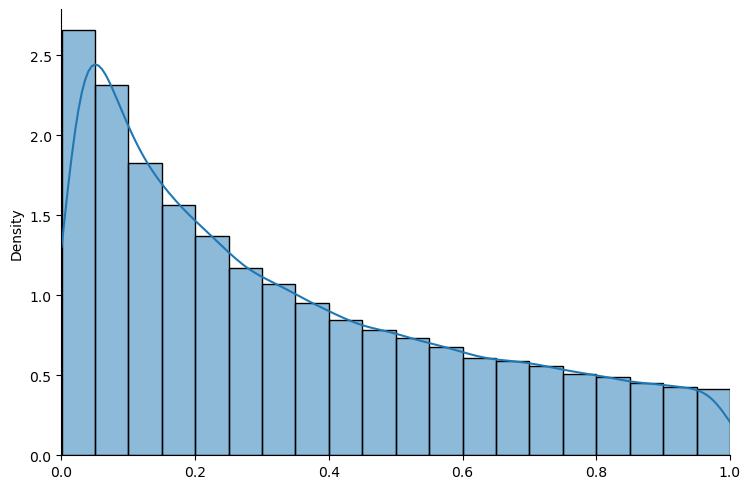

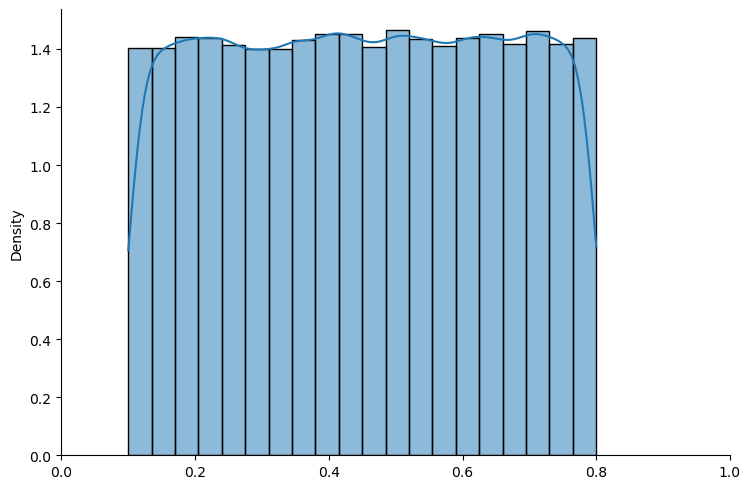

In [6]:
# truncated log normal
exampleLN = BayesianInference(param=(0,2), name_dist='lognormal', solver='numpyro')
exampleLN.show_prior(size=100000,bins=20)

# truncated uniform
exampleUN = BayesianInference(param=(0.1,0.8), name_dist='uniform', solver='numpyro')
exampleUN.show_prior(size=100000,bins=20)

The above graphs show that sampling seems to work well with both distributions.


Now let's see how well things work with a couple of von Mises distributions.

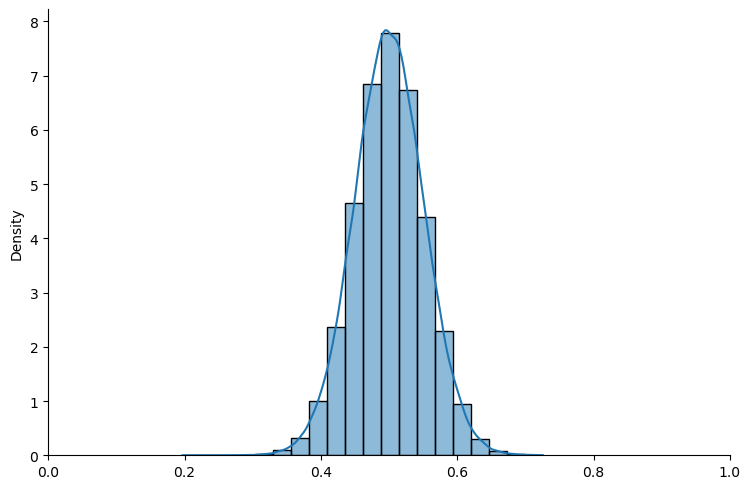

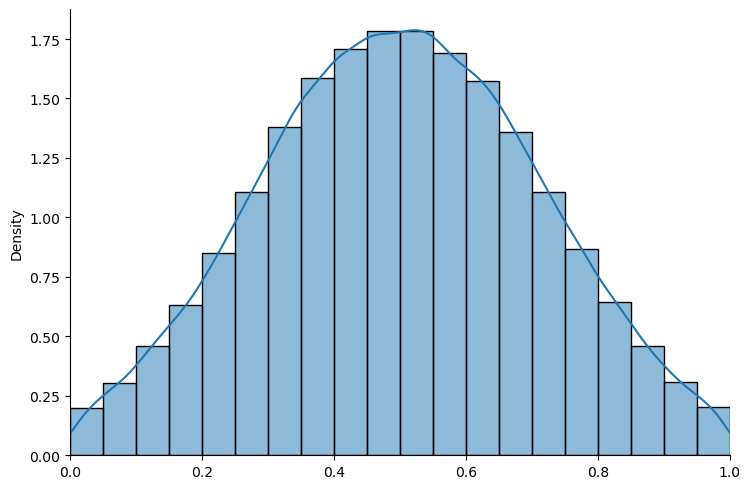

In [7]:
# shifted von Mises
exampleVM = BayesianInference(param=10, name_dist='vonMises', solver='numpyro')
exampleVM.show_prior(size=100000,bins=20)

# truncated von Mises
exampleVM_trunc = BayesianInference(param=20, name_dist='vonMises', solver='pyro')
exampleVM_trunc.show_prior(size=100000,bins=20)

These graphs look good too.

Now let's try with a Laplace distribution.

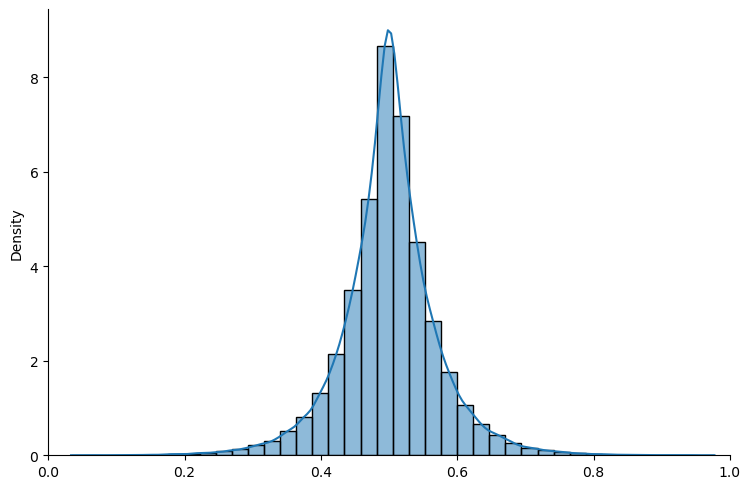

In [8]:
# truncated Laplace
exampleLP = BayesianInference(param=(0.5,0.05), name_dist='laplace', solver='numpyro')
exampleLP.show_prior(size=100000,bins=40)

Having assured ourselves that our sampler seems to do a good job, let's put it to work in using MCMC to compute posterior probabilities.

## Posteriors Via MCMC and VI

We construct a class  `BayesianInferencePlot` to implement MCMC or VI algorithms and plot multiple posteriors for different updating data sizes and different  possible prior. 

This class takes as inputs the true data generating parameter 'theta', a list of updating data sizes for multiple posterior plotting, and a defined and parametrized `BayesianInference` class.

It has two key methods: 

- `BayesianInferencePlot.MCMC_plot()` takes wanted MCMC sample size as input and plot the output posteriors  together with the prior defined in `BayesianInference` class.

- `BayesianInferencePlot.SVI_plot()` takes wanted VI distribution class ('beta' or 'normal') as input and plot the posteriors together with the prior.

In [9]:
class BayesianInferencePlot:
    """
    Easily implement the MCMC and VI inference for a given instance of BayesianInference class and
    plot the prior together with multiple posteriors

    Parameters
    ----------
    theta : float.
        the true DGP parameter
    N_list : list.
        a list of sample size
    BayesianInferenceClass : class.
        a class initiated using BayesianInference()

    """

    def __init__(self, theta, N_list, BayesianInferenceClass, binwidth=0.02):
        """
        Enter Parameters for data generation and plotting
        """
        self.theta = theta
        self.N_list = N_list
        self.BayesianInferenceClass = BayesianInferenceClass

        # plotting parameters
        self.binwidth = binwidth
        self.linewidth=0.05
        self.colorlist = sns.color_palette(n_colors=len(N_list))

        # data generation
        N_max = max(N_list)
        self.data = simulate_draw(theta, N_max)

    
    def MCMC_plot(self, num_samples, num_warmup=1000):
        """
        Parameters as in MCMC_sampling except that data is already defined
        """
        fig, ax = plt.subplots(figsize=(10, 6))

        # plot prior
        prior_sample = self.BayesianInferenceClass.show_prior(disp_plot=0)
        sns.histplot(
            data=prior_sample, kde=True, stat='density', 
            binwidth=self.binwidth,
            color='#4C4E52', 
            linewidth=self.linewidth,
            alpha=0.1,
            ax=ax,
            label='Prior Distribution'
            )

        # plot posteriors
        for id, n in enumerate(self.N_list):
            samples = self.BayesianInferenceClass.MCMC_sampling(
                self.data[:n], num_samples, num_warmup
            )
            sns.histplot(
                samples, kde=True, stat='density', 
                binwidth=self.binwidth, 
                linewidth=self.linewidth,
                alpha=0.2,
                color=self.colorlist[id-1],
                label=f'Posterior with $n={n}$'
                )
        ax.legend()
        ax.set_title('MCMC Sampling density of Posterior Distributions', fontsize=15)
        plt.xlim(0, 1)
        plt.show()


    def SVI_fitting(self, guide_dist, params):
        """
        Fit the beta/truncnormal curve using parameters trained by SVI. 
        I create plot using PDF given by scipy.stats distributions since torch.dist do not have embedded PDF methods.
        """
        # create x axis
        xaxis = np.linspace(0,1,1000)
        if guide_dist=='beta':
            y = st.beta.pdf(xaxis, a=params['alpha_q'], b=params['beta_q'])

        elif guide_dist=='normal':

            # rescale upper/lower bound. See Scipy's truncnorm doc
            lower, upper = (0, 1)
            loc, scale = params['loc'], params['scale']
            a, b = (lower - loc) / scale, (upper - loc) / scale

            y = st.truncnorm.pdf(xaxis, a=a, b=b, loc=params['loc'], scale=params['scale'])
        return (xaxis, y)
        

    def SVI_plot(self, guide_dist, n_steps=2000):
        """
        Parameters as in SVI_run except that data is already defined
        """
        fig, ax = plt.subplots(figsize=(10, 6))

        # plot prior
        prior_sample = self.BayesianInferenceClass.show_prior(disp_plot=0)
        sns.histplot(
            data=prior_sample, kde=True, stat='density', 
            binwidth=self.binwidth,
            color='#4C4E52', 
            linewidth=self.linewidth,
            alpha=0.1,
            ax=ax,
            label='Prior Distribution'
            )

        # plot posteriors
        for id, n in enumerate(self.N_list):
            (params, losses) = self.BayesianInferenceClass.SVI_run(self.data[:n], guide_dist, n_steps)
            x, y = self.SVI_fitting(guide_dist, params)
            ax.plot(x, y,
                alpha=1,
                color=self.colorlist[id-1],
                label=f'Posterior with $n={n}$'
                )
        ax.legend()
        ax.set_title(f'SVI density of Posterior Distributions with {guide_dist} guide', fontsize=15)
        plt.xlim(0, 1)
        plt.show()

Let's set some parameters that we'll use in all of the examples  below.

To save computer time at first, notice that  we'll set `MCMC_num_samples = 2000` and `SVI_num_steps = 5000`.

(Later, to increase accuracy of approximations, we'll want to increase these.)

In [10]:
num_list = [5,10,50,100,1000]
MCMC_num_samples = 2000
SVI_num_steps = 5000

# theta is the data generating process
true_theta = 0.8

### Beta Prior and Posteriors:

Let's compare outcomes when we use a Beta prior.

For the same Beta prior, we shall 

* compute posteriors analytically
* compute posteriors using MCMC  via  `Pyro` and `Numpyro`.
* compute posteriors using  VI via  `Pyro` and `Numpyro`.

Let's start with the analytical method that we described in this quantecon lecture <https://python.quantecon.org/prob_meaning.html>

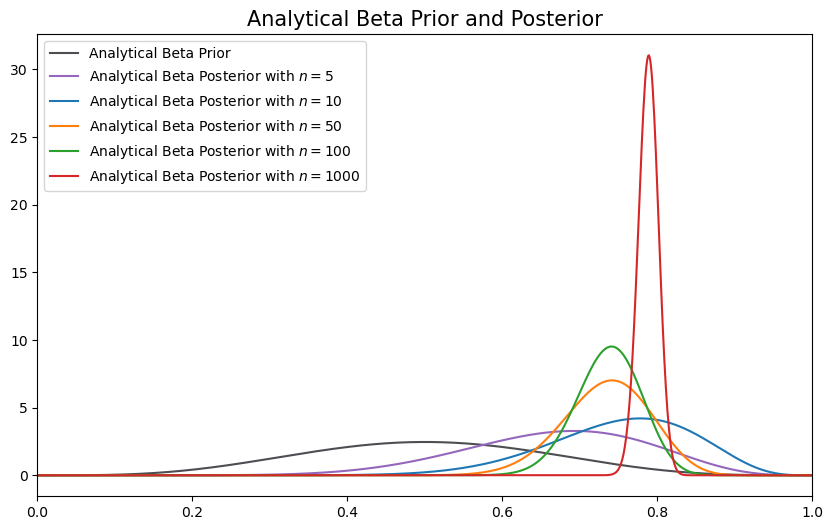

In [11]:
# First examine Beta priors
BETA_pyro = BayesianInference(param=(5,5), name_dist='beta', solver='pyro')
BETA_numpyro = BayesianInference(param=(5,5), name_dist='beta', solver='numpyro')

BETA_pyro_plot = BayesianInferencePlot(true_theta, num_list, BETA_pyro)
BETA_numpyro_plot = BayesianInferencePlot(true_theta, num_list, BETA_numpyro)


# plot analytical Beta prior and posteriors
xaxis = np.linspace(0,1,1000)
y_prior = st.beta.pdf(xaxis, 5, 5)

fig, ax = plt.subplots(figsize=(10, 6))
# plot analytical beta prior
ax.plot(xaxis, y_prior, label='Analytical Beta Prior', color='#4C4E52')

data, colorlist, N_list = BETA_pyro_plot.data, BETA_pyro_plot.colorlist, BETA_pyro_plot.N_list
# plot analytical beta posteriors
for id, n in enumerate(N_list):
    func = analytical_beta_posterior(data[:n], alpha0=5, beta0=5)
    y_posterior = func.pdf(xaxis)
    ax.plot(
        xaxis, y_posterior, color=colorlist[id-1], label=f'Analytical Beta Posterior with $n={n}$')
ax.legend()
ax.set_title('Analytical Beta Prior and Posterior', fontsize=15)
plt.xlim(0, 1)
plt.show()

Now let's use MCMC while still using a beta prior.  

We'll do this for both MCMC and VI.

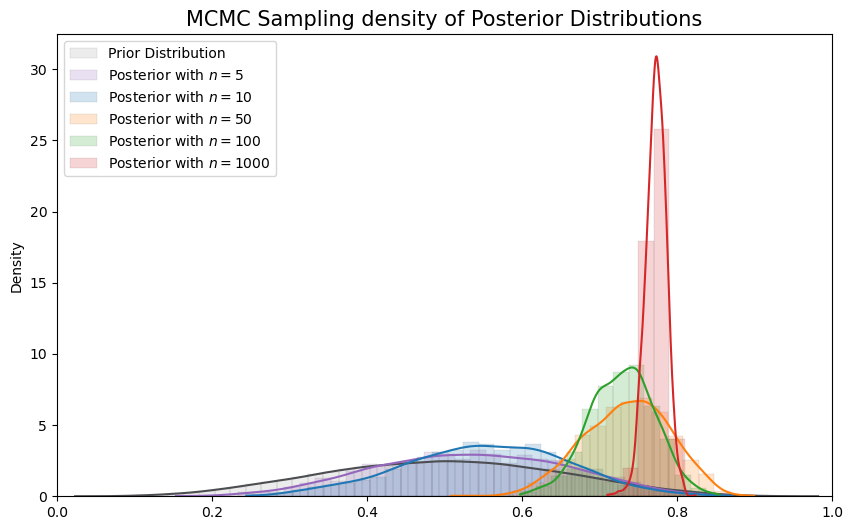

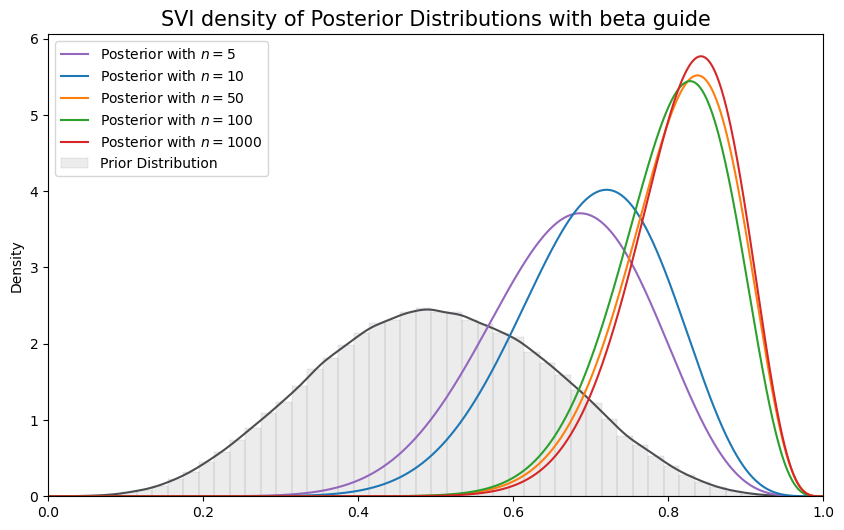

In [12]:
BayesianInferencePlot(true_theta, num_list, BETA_pyro).MCMC_plot(num_samples=MCMC_num_samples)
BayesianInferencePlot(true_theta, num_list, BETA_numpyro).SVI_plot(guide_dist='beta', n_steps=SVI_num_steps)

Here the MCMC approximation looks good.

But the VI approximation doesn't look so good.

* even though we use the  beta distribution as our guide, the VI approximated posterior distributions do not closely resemble the posteriors that we had just computed analytically. 

(Here, our initial parameter for Beta guide is (0.5, 0.5).)


But if we increase the number of  steps from 5000 to 10000 in VI as we now shall do, we'll get VI-approximated   posteriors
will be  more accurate, as we shall see next. 

(Increasing the step size increases computational time though).

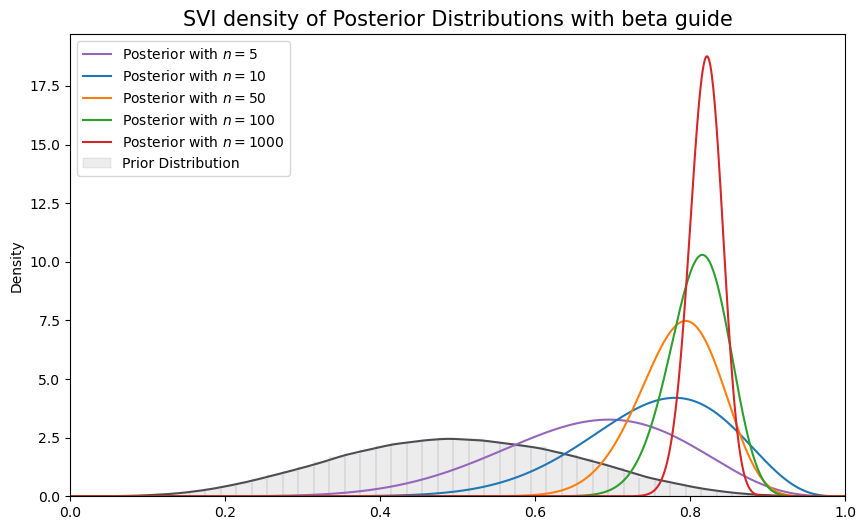

In [13]:
BayesianInferencePlot(true_theta, num_list, BETA_numpyro).SVI_plot(guide_dist='beta', n_steps=100000)

## Non-conjugate Prior Distributions

Having assured ourselves that our MCMC and VI methods can work well when we have  conjugate prior and so can also compute analytically, we 
next proceed to situations in which our  prior  is not a beta distribution, so we don't have a conjugate prior.

So we will have non-conjugate priors and are cast into situations in which we can't calculate posteriors analytically.

### MCMC 

First, we implement and display  MCMC. 

We first initialize the `BayesianInference` classes and then can directly call `BayesianInferencePlot` to plot both MCMC and SVI approximating posteriors.

In [14]:
# Initialize BayesianInference classes
# try uniform
STD_UNIFORM_pyro = BayesianInference(param=(0,1), name_dist='uniform', solver='pyro')
UNIFORM_numpyro = BayesianInference(param=(0.2,0.7), name_dist='uniform', solver='numpyro')

# try truncated lognormal
LOGNORMAL_numpyro = BayesianInference(param=(0,2), name_dist='lognormal', solver='numpyro')
LOGNORMAL_pyro = BayesianInference(param=(0,2), name_dist='lognormal', solver='pyro')

# try von Mises
# shifted von Mises
VONMISES_numpyro = BayesianInference(param=10, name_dist='vonMises', solver='numpyro')
# truncated von Mises
VONMISES_pyro = BayesianInference(param=40, name_dist='vonMises', solver='pyro')

# try laplace
LAPLACE_numpyro = BayesianInference(param=(0.5, 0.07), name_dist='laplace', solver='numpyro')

=======INFO=======
Parameters: (0, 1)
Prior Dist: uniform
Solver: pyro


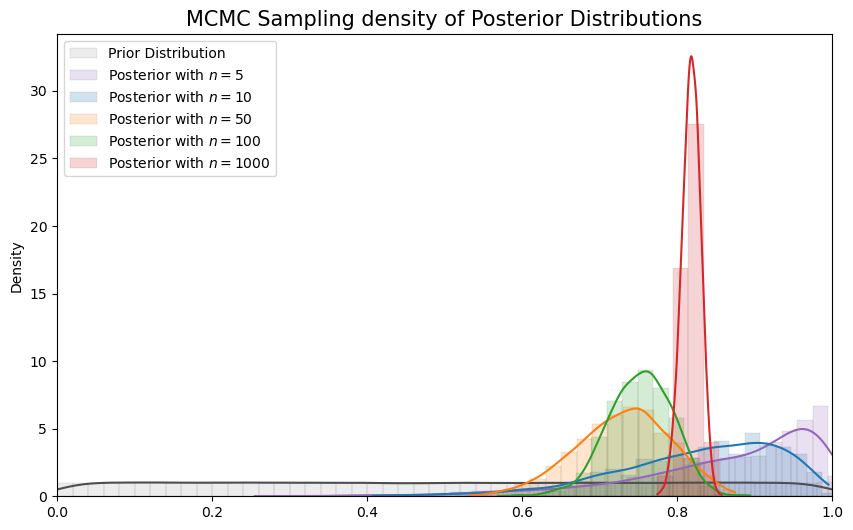

=======INFO=======
Parameters: (0.2, 0.7)
Prior Dist: uniform
Solver: numpyro


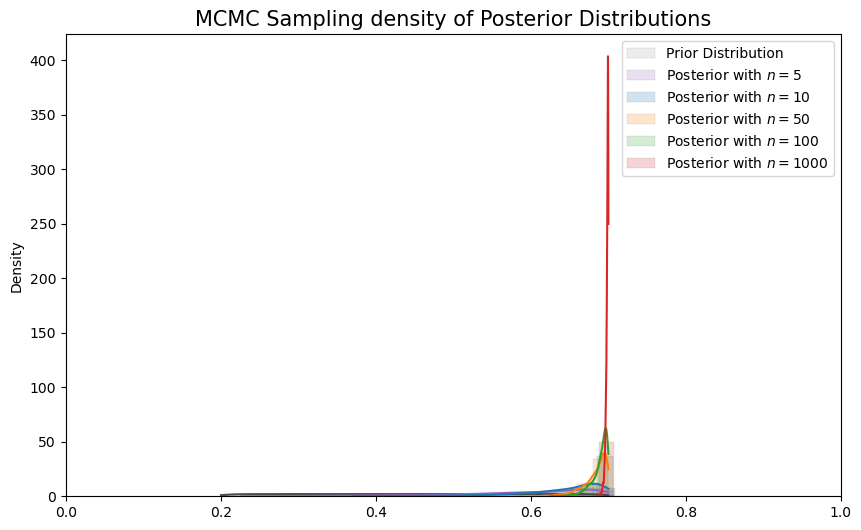

In [15]:
# Uniform
example_CLASS = STD_UNIFORM_pyro
print(f'=======INFO=======\nParameters: {example_CLASS.param}\nPrior Dist: {example_CLASS.name_dist}\nSolver: {example_CLASS.solver}')
BayesianInferencePlot(true_theta, num_list, example_CLASS).MCMC_plot(num_samples=MCMC_num_samples)

example_CLASS = UNIFORM_numpyro
print(f'=======INFO=======\nParameters: {example_CLASS.param}\nPrior Dist: {example_CLASS.name_dist}\nSolver: {example_CLASS.solver}')
BayesianInferencePlot(true_theta, num_list, example_CLASS).MCMC_plot(num_samples=MCMC_num_samples)

In the situation depicted above, we have assumed a  $Uniform(\underline{\theta}, \overline{\theta})$ prior that puts zero probability   outside a bounded support that excludes the true value.

Consequently,  the posterior cannot put positive probability above $\overline{\theta}$ or below $\underline{\theta}$.

Note how when  the true data-generating $\theta$ is located at $0.8$ as it is here,  when $n$ gets large, the posterior  concentrate on the upper bound of the support of the prior,  $0.7$ here.

=======INFO=======
Parameters: (0, 2)
Prior Dist: lognormal
Solver: numpyro


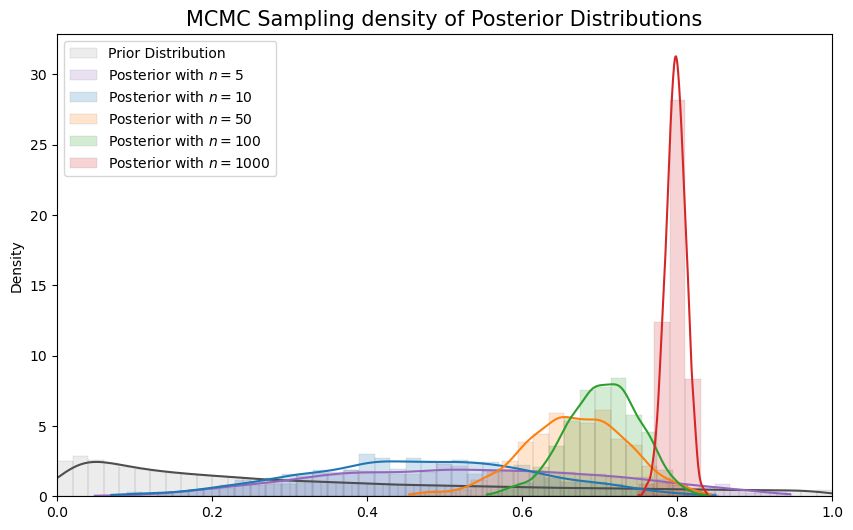

=======INFO=======
Parameters: (0, 2)
Prior Dist: lognormal
Solver: pyro


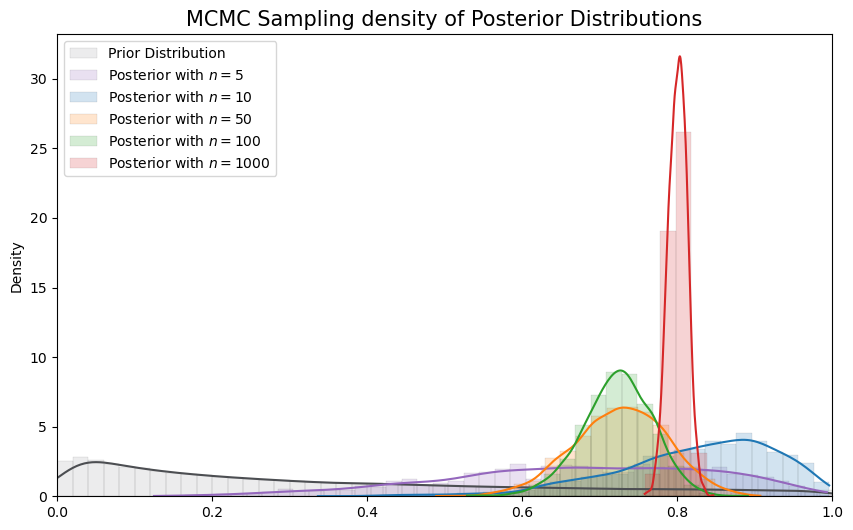

In [16]:
# Log Normal
example_CLASS = LOGNORMAL_numpyro
print(f'=======INFO=======\nParameters: {example_CLASS.param}\nPrior Dist: {example_CLASS.name_dist}\nSolver: {example_CLASS.solver}')
BayesianInferencePlot(true_theta, num_list, example_CLASS).MCMC_plot(num_samples=MCMC_num_samples)

example_CLASS = LOGNORMAL_pyro
print(f'=======INFO=======\nParameters: {example_CLASS.param}\nPrior Dist: {example_CLASS.name_dist}\nSolver: {example_CLASS.solver}')
BayesianInferencePlot(true_theta, num_list, example_CLASS).MCMC_plot(num_samples=MCMC_num_samples)

=======INFO=======
Parameters: 10
Prior Dist: vonMises
Solver: numpyro

NOTE: Shifted von Mises


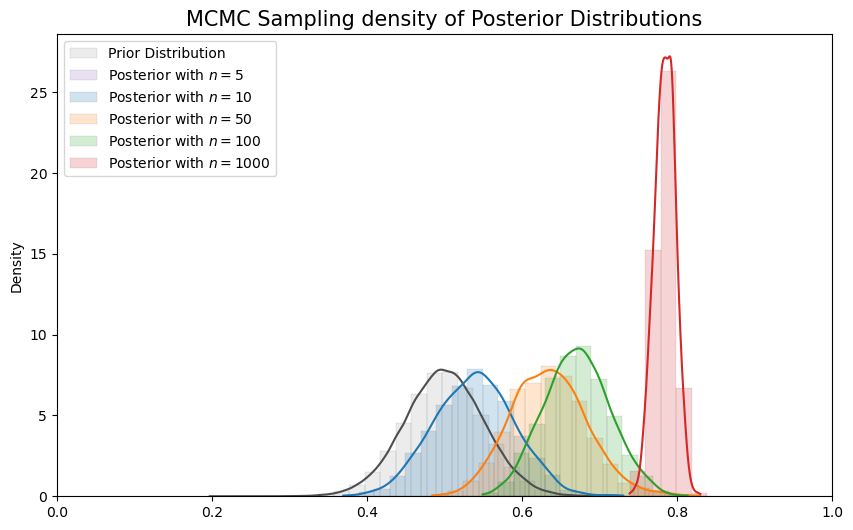

=======INFO=======
Parameters: 40
Prior Dist: vonMises
Solver: pyro

NOTE: Truncated von Mises


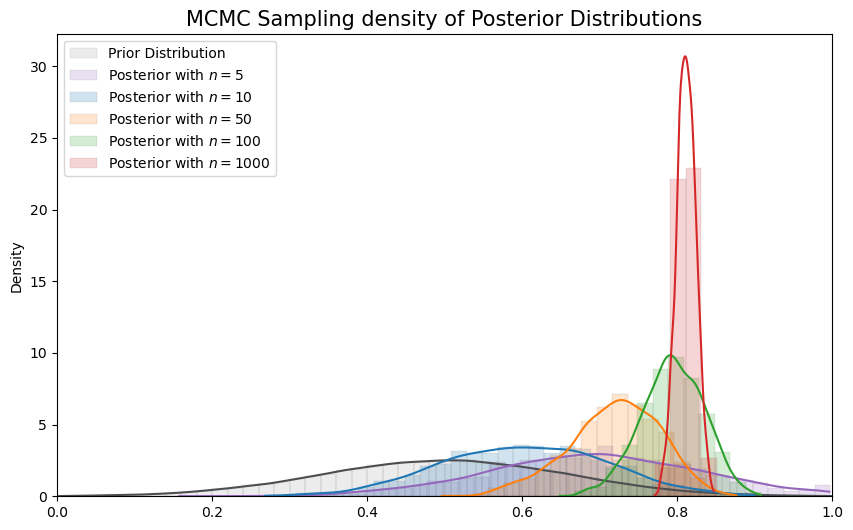

In [17]:
# Von Mises
example_CLASS = VONMISES_numpyro
print(f'=======INFO=======\nParameters: {example_CLASS.param}\nPrior Dist: {example_CLASS.name_dist}\nSolver: {example_CLASS.solver}')
print('\nNOTE: Shifted von Mises')
BayesianInferencePlot(true_theta, num_list, example_CLASS).MCMC_plot(num_samples=MCMC_num_samples)

example_CLASS = VONMISES_pyro
print(f'=======INFO=======\nParameters: {example_CLASS.param}\nPrior Dist: {example_CLASS.name_dist}\nSolver: {example_CLASS.solver}')
print('\nNOTE: Truncated von Mises')
BayesianInferencePlot(true_theta, num_list, example_CLASS).MCMC_plot(num_samples=MCMC_num_samples)

=======INFO=======
Parameters: (0.5, 0.07)
Prior Dist: laplace
Solver: numpyro


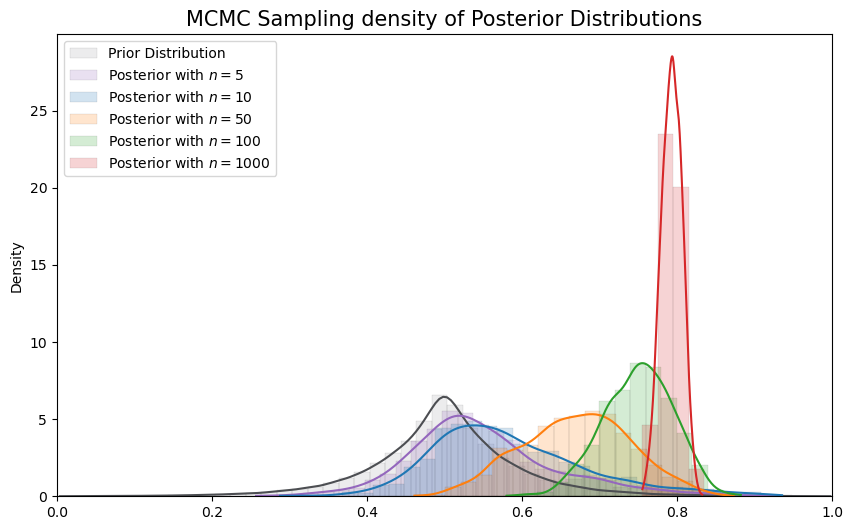

In [18]:
# Laplace
example_CLASS = LAPLACE_numpyro
print(f'=======INFO=======\nParameters: {example_CLASS.param}\nPrior Dist: {example_CLASS.name_dist}\nSolver: {example_CLASS.solver}')
BayesianInferencePlot(true_theta, num_list, example_CLASS).MCMC_plot(num_samples=MCMC_num_samples)

To get more accuracy we will now increase the number of steps for Variational Inference (VI)

In [19]:
SVI_num_steps = 50000

#### VI with a  Truncated Normal Guide

=======INFO=======
Parameters: (0, 1)
Prior Dist: uniform
Solver: numpyro


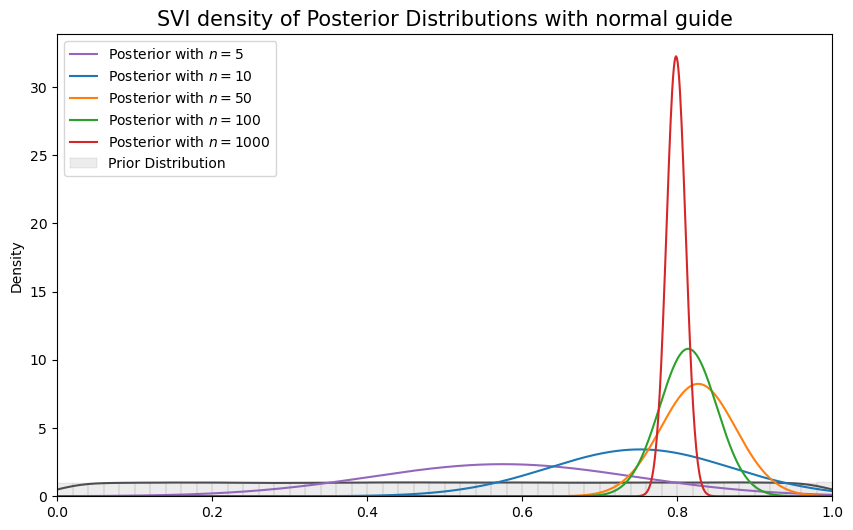

In [20]:
# Uniform
example_CLASS = BayesianInference(param=(0,1), name_dist='uniform', solver='numpyro')
print(f'=======INFO=======\nParameters: {example_CLASS.param}\nPrior Dist: {example_CLASS.name_dist}\nSolver: {example_CLASS.solver}')
BayesianInferencePlot(true_theta, num_list, example_CLASS).SVI_plot(guide_dist='normal', n_steps=SVI_num_steps)


=======INFO=======
Parameters: (0, 2)
Prior Dist: lognormal
Solver: numpyro


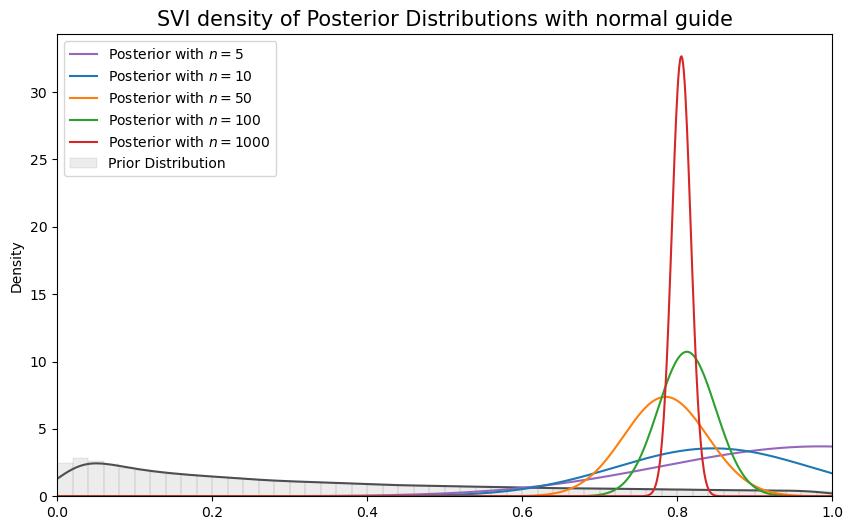

In [21]:
# Log Normal
example_CLASS = LOGNORMAL_numpyro
print(f'=======INFO=======\nParameters: {example_CLASS.param}\nPrior Dist: {example_CLASS.name_dist}\nSolver: {example_CLASS.solver}')
BayesianInferencePlot(true_theta, num_list, example_CLASS).SVI_plot(guide_dist='normal', n_steps=SVI_num_steps)

=======INFO=======
Parameters: 10
Prior Dist: vonMises
Solver: numpyro

NB: Shifted von Mises


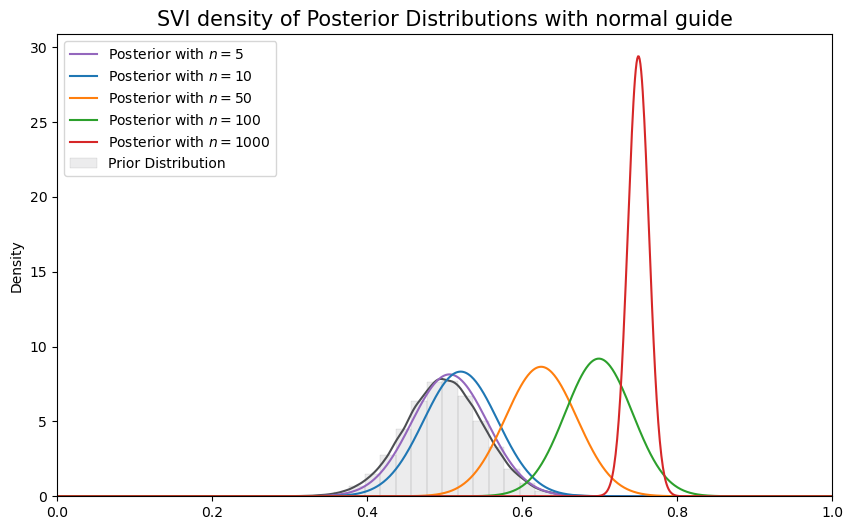

In [22]:
# Von Mises
example_CLASS = VONMISES_numpyro
print(f'=======INFO=======\nParameters: {example_CLASS.param}\nPrior Dist: {example_CLASS.name_dist}\nSolver: {example_CLASS.solver}')
print('\nNB: Shifted von Mises')
BayesianInferencePlot(true_theta, num_list, example_CLASS).SVI_plot(guide_dist='normal', n_steps=SVI_num_steps)

=======INFO=======
Parameters: (0.5, 0.07)
Prior Dist: laplace
Solver: numpyro


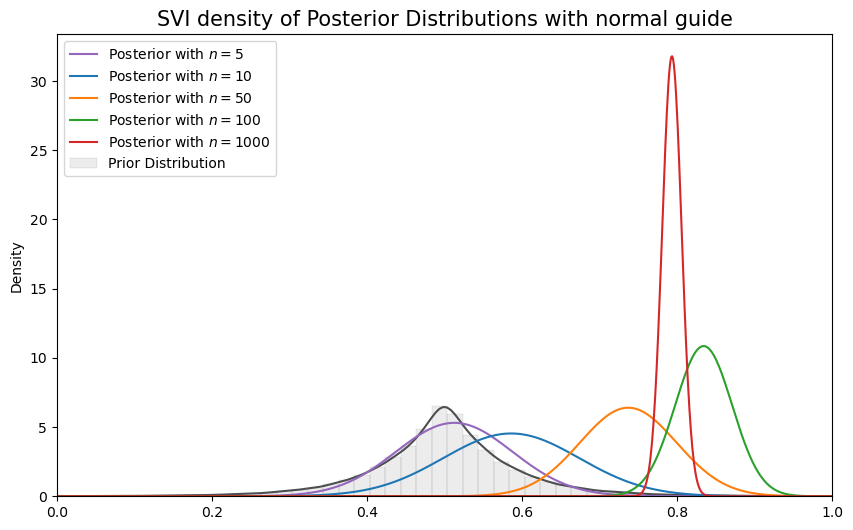

In [23]:
# Laplace
example_CLASS = LAPLACE_numpyro
print(f'=======INFO=======\nParameters: {example_CLASS.param}\nPrior Dist: {example_CLASS.name_dist}\nSolver: {example_CLASS.solver}')
BayesianInferencePlot(true_theta, num_list, example_CLASS).SVI_plot(guide_dist='normal', n_steps=SVI_num_steps)

#### Variational Inference with a  Beta Guide Distribution

=======INFO=======
Parameters: (0, 1)
Prior Dist: uniform
Solver: pyro


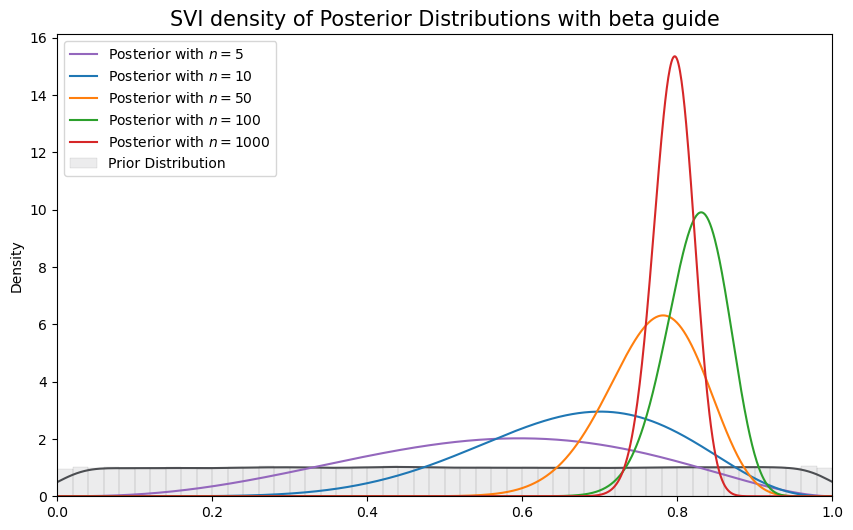

In [24]:
# Uniform
example_CLASS = STD_UNIFORM_pyro
print(f'=======INFO=======\nParameters: {example_CLASS.param}\nPrior Dist: {example_CLASS.name_dist}\nSolver: {example_CLASS.solver}')
BayesianInferencePlot(true_theta, num_list, example_CLASS).SVI_plot(guide_dist='beta', n_steps=SVI_num_steps)

=======INFO=======
Parameters: (0, 2)
Prior Dist: lognormal
Solver: numpyro


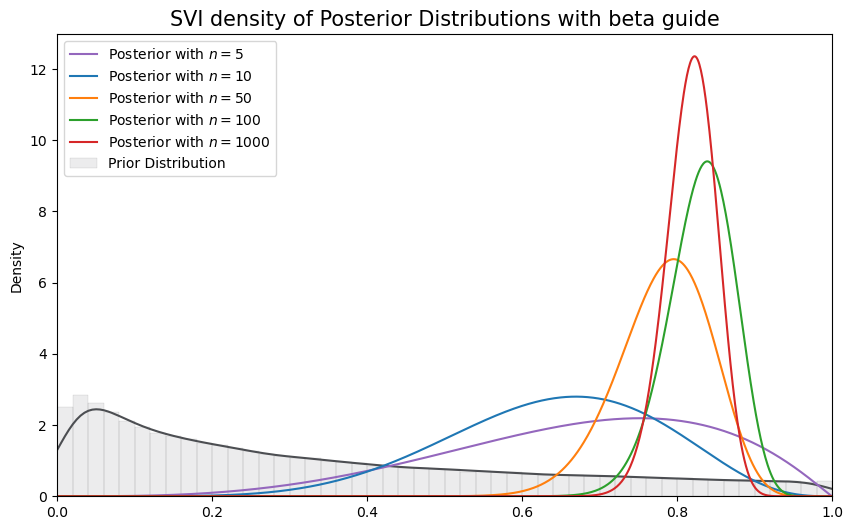

=======INFO=======
Parameters: (0, 2)
Prior Dist: lognormal
Solver: pyro


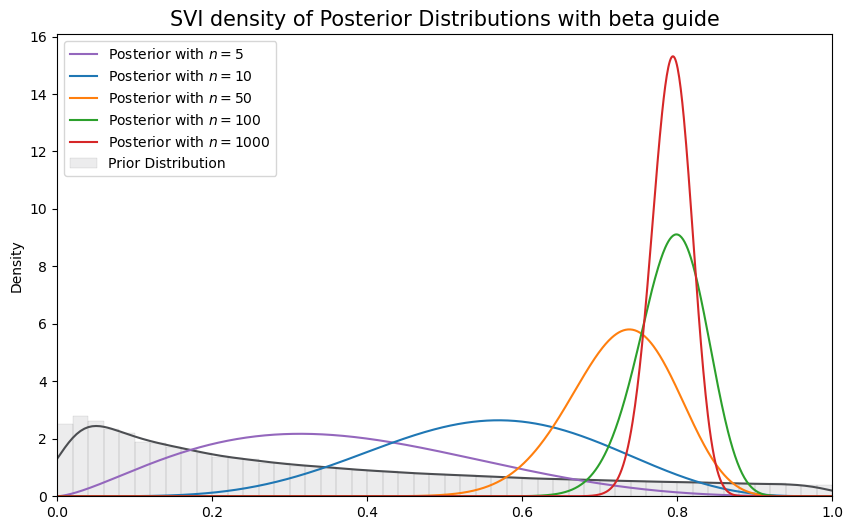

In [25]:
# Log Normal
example_CLASS = LOGNORMAL_numpyro
print(f'=======INFO=======\nParameters: {example_CLASS.param}\nPrior Dist: {example_CLASS.name_dist}\nSolver: {example_CLASS.solver}')
BayesianInferencePlot(true_theta, num_list, example_CLASS).SVI_plot(guide_dist='beta', n_steps=SVI_num_steps)

example_CLASS = LOGNORMAL_pyro
print(f'=======INFO=======\nParameters: {example_CLASS.param}\nPrior Dist: {example_CLASS.name_dist}\nSolver: {example_CLASS.solver}')
BayesianInferencePlot(true_theta, num_list, example_CLASS).SVI_plot(guide_dist='beta', n_steps=SVI_num_steps)

=======INFO=======
Parameters: 10
Prior Dist: vonMises
Solver: numpyro

NB: Shifted von Mises


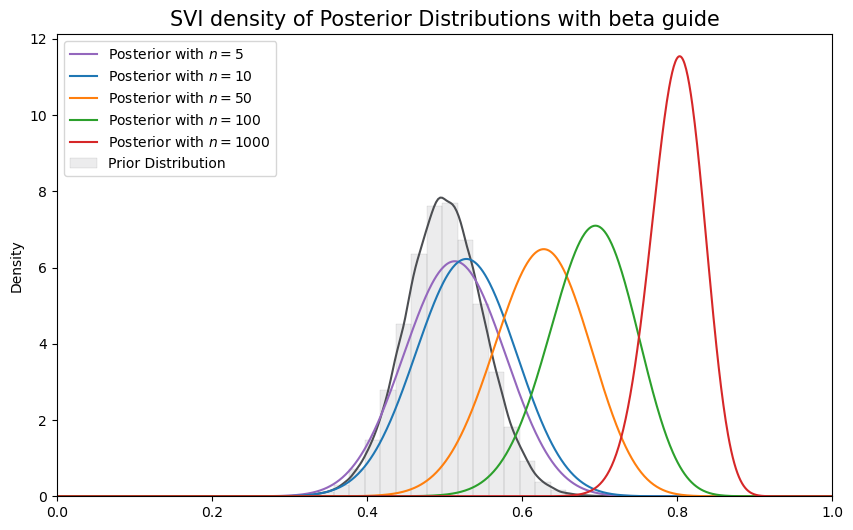

=======INFO=======
Parameters: 40
Prior Dist: vonMises
Solver: pyro

NB: Truncated von Mises


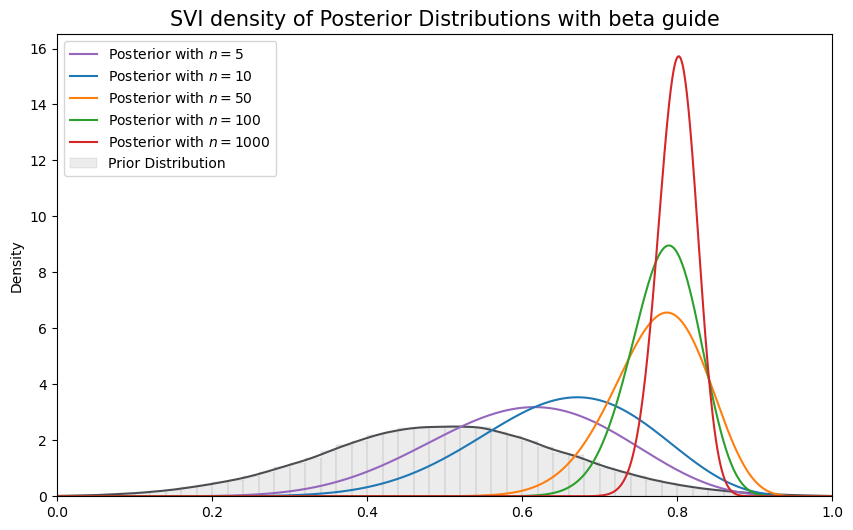

In [26]:
# Von Mises
example_CLASS = VONMISES_numpyro
print(f'=======INFO=======\nParameters: {example_CLASS.param}\nPrior Dist: {example_CLASS.name_dist}\nSolver: {example_CLASS.solver}')
print('\nNB: Shifted von Mises')
BayesianInferencePlot(true_theta, num_list, example_CLASS).SVI_plot(guide_dist='beta', n_steps=SVI_num_steps)

example_CLASS = VONMISES_pyro
print(f'=======INFO=======\nParameters: {example_CLASS.param}\nPrior Dist: {example_CLASS.name_dist}\nSolver: {example_CLASS.solver}')
print('\nNB: Truncated von Mises')
BayesianInferencePlot(true_theta, num_list, example_CLASS).SVI_plot(guide_dist='beta', n_steps=SVI_num_steps)

=======INFO=======
Parameters: (0.5, 0.07)
Prior Dist: laplace
Solver: numpyro


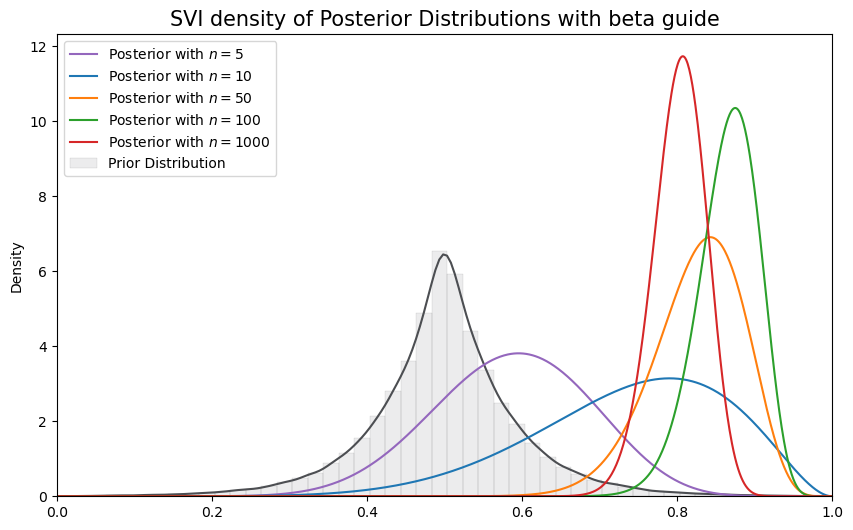

In [27]:
# Laplace
example_CLASS = LAPLACE_numpyro
print(f'=======INFO=======\nParameters: {example_CLASS.param}\nPrior Dist: {example_CLASS.name_dist}\nSolver: {example_CLASS.solver}')
BayesianInferencePlot(true_theta, num_list, example_CLASS).SVI_plot(guide_dist='beta', n_steps=SVI_num_steps)